In [1]:
%load_ext autoreload
%autoreload 2  

import sys, os, re

dir_home = re.sub( 'QBioCode.*', 'QBioCode', os.getcwd() )

sys.path.append( dir_home )

import qbiocode as qbc

/Users/krhriss/IBM/QBioCode/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



# Examples of how to run Profiler with some artifical datasets

## Generate data

In [2]:

type_of_data = 'classes'

N_SAMPLES = [100]
N_FEATURES = [10]
N_INFORMATIVE = [2]
N_REDUNDANT = [2]
N_CLASSES = [2]
N_CLUSTERS_PER_CLASS = [2]
WEIGHTS = [[0.3, 0.7], [0.4, 0.6], [0.5, 0.5]]

qbc.generate_data(
    type_of_data=type_of_data,
    save_path= os.path.join( 'data', 'ld_data' ),
    n_samples=N_SAMPLES,
    n_features=N_FEATURES,
    n_informative=N_INFORMATIVE,
    n_redundant=N_REDUNDANT,
    n_classes=N_CLASSES,
    n_clusters_per_class=N_CLUSTERS_PER_CLASS,
    weights=WEIGHTS,
)

Generating classes dataset...
Dataset generation complete.


## Running Profiler

To run Profiler, configure a YAML that will capture the experimental parameters you are interested in testing.  

Profiler can be called from the commandline as below
```
python apps/profiler/profiler.py --config-path=[path to QBioCode]/tutorial/Profiler/configs --config-name=config.yaml
```

Or as follows

In [3]:
import apps.profiler.profiler as profiler
import yaml

config = yaml.safe_load(open('configs/config.yaml', 'r'))

profiler.main(config)

Processing file: class_data-1.csv
Currently running a quantum support vector classifier (QSVC) on this dataset.
The number of qubits in your circuit is: 3
The number of parameters in your circuit is: 3
at datapoint 0
at datapoint 0
Currently running a quantum support vector classifier (QSVC) on this dataset.
The number of qubits in your circuit is: 3
The number of parameters in your circuit is: 3
at datapoint 0
at datapoint 0
Currently running a quantum support vector classifier (QSVC) on this dataset.
The number of qubits in your circuit is: 10
The number of parameters in your circuit is: 10
at datapoint 0
at datapoint 0
Currently running a quantum support vector classifier (QSVC) on this dataset.
The number of qubits in your circuit is: 3
The number of parameters in your circuit is: 3
at datapoint 0
at datapoint 0
Currently running a quantum support vector classifier (QSVC) on this dataset.
The number of qubits in your circuit is: 3
The number of parameters in your circuit is: 3
at d

## Visualize results

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import math

data_evals = [os.path.join(dp, f) for dp, dn, filenames in os.walk(os.path.join(dir_home, 'tutorial', 'Profiler')) for f in filenames if f == 'RawDataEvaluation.csv']
data_result = [os.path.join(dp, f) for dp, dn, filenames in os.walk(os.path.join(dir_home, 'tutorial', 'Profiler')) for f in filenames if f == 'ModelResults.csv']

rawevals_df=[]
for fl in data_evals:
    rawevals_df.append(pd.read_csv(fl))
rawevals_df = pd.concat(rawevals_df)
# this will create a dataframe with all the data complexity evaluations, and save it to a csv file
rawevals_df.to_csv( 'compiled_raw_data_evaluations.csv', index=False )
results_df = []
for fl in data_result:
    results_df.append( pd.read_csv(fl) )
results_df = pd.concat( results_df )
# these two lines below add a couple columns to the dataframe, consolidating certain information that will be useful for plotting later
results_df['datatype'] = [ re.sub( '-.*', '', x ) for x in results_df['Dataset'] ]
results_df[ 'model_embed_datatype'] = [ row.model + '_' + row.embeddings + '_' + row.datatype for idx, row in results_df.iterrows() ]
# this will create a dataframe with all the data model results, and save it to a csv file
results_df.to_csv( 'compiled_results.csv', index=False )

# use this tag to give a quick name for all outputs, reflecting what your input data sets were
tag = 'tutorial_data'

## establish output directory 
output_dir =  'performance_summary_and_spearman_correlation_plots'
if not os.path.exists( output_dir ):
    os.makedirs( output_dir )

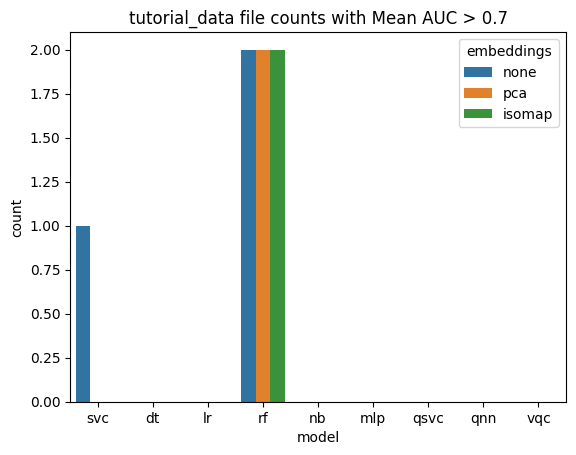

In [9]:
## looking at AUC

import seaborn as sns
tmp = results_df.groupby(['model','embeddings','Dataset'])['auc'].mean().reset_index()
desired_order = ['svc', 'dt', 'lr', 'rf', 'nb', 'mlp', 'qsvc', 'qnn', 'vqc']
# desired_order = ['qsvc', 'svc', 'rf','mlp']
tmp['model'] = pd.Categorical(tmp['model'], categories=desired_order, ordered=True)
tmp = tmp.sort_values(by='model')
tmp = tmp.reset_index(drop=True)
ax=sns.countplot(tmp[tmp["auc"]>0.7], x='model', hue='embeddings')
ax.set_title(f'{tag} file counts with Mean AUC > 0.7')
plt.show
plt.savefig( os.path.join( output_dir,  tag + '-count_auc.png') )

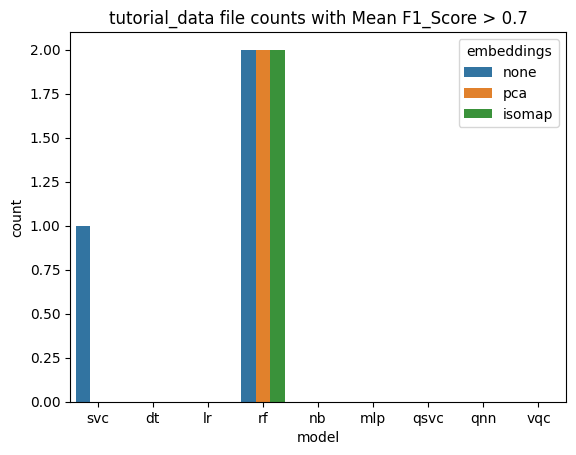

In [10]:
## looking at F1

import seaborn as sns
tmp = results_df.groupby(['model','embeddings','Dataset'])['f1_score'].mean().reset_index()
desired_order = ['svc', 'dt', 'lr', 'rf', 'nb', 'mlp', 'qsvc', 'qnn', 'vqc']
# desired_order = ['qsvc', 'svc', 'rf','mlp']
tmp['model'] = pd.Categorical(tmp['model'], categories=desired_order, ordered=True)
tmp = tmp.sort_values(by='model')
tmp = tmp.reset_index(drop=True)
ax=sns.countplot(tmp[tmp["f1_score"]>0.7], x='model', hue='embeddings')
ax.set_title(f'{tag} file counts with Mean F1_Score > 0.7')
plt.show
plt.savefig( os.path.join( output_dir,  tag + '-count_f1.png') )


In [11]:
# Let's see if we can find data sets where qml won
# Regardless, this function still produces a data frame with the average best performance per model, across the data sets.
qbc.qml_winner(results_df, rawevals_df, output_dir, tag)

       Mean_F1_Score  Median_F1_Score  Max_F1_Score  StandardDev_F1_Score
model                                                                    
pqk         0.886597         0.983037      1.000000              0.181928
qsvc        0.532948         0.572374      0.576471              0.071864
rf          0.851721         0.922956      0.965585              0.161712
svc         0.579749         0.576471      0.712776              0.131419
*** QML methods were outperformed by CML methods in all datasets ***


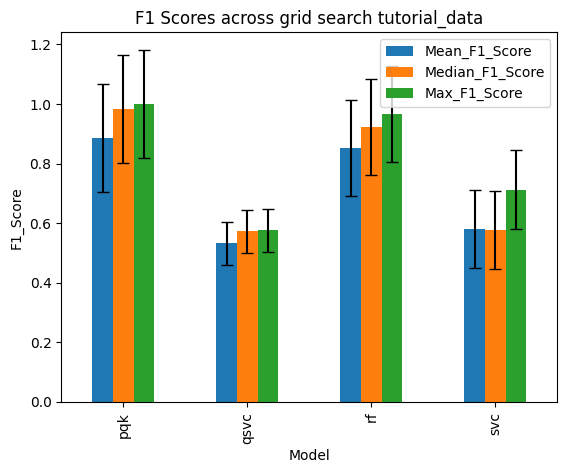

In [12]:
import pandas as pd
import numpy as np

# Sample DataFrame

df = pd.read_csv(os.path.join( output_dir, tag + '_best_permodel_summary.csv') )

# Plotting the barplot with error bars
ax = df.plot.bar(x='model', y=['Mean_F1_Score', 'Median_F1_Score', 'Max_F1_Score'], yerr='StandardDev_F1_Score', capsize=4)


import matplotlib.pyplot as plt

# Add title and labels
plt.title(f'F1 Scores across grid search {tag}')
plt.xlabel('Model')
plt.ylabel('F1_Score')

# Adjust appearance
# ax.patches[0].set_facecolor('skyblue')
# ax.patches[1].set_facecolor('lightcoral')
# ax.patches[2].set_facecolor('lightgreen')

# Show the plot
plt.savefig(os.path.join( output_dir, tag + '_F1summary.png'), bbox_inches='tight')
plt.show()

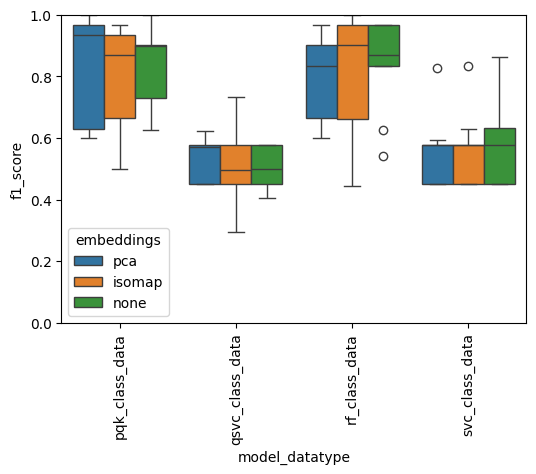

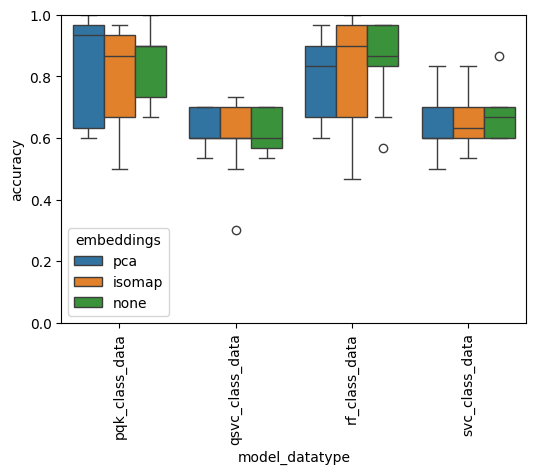

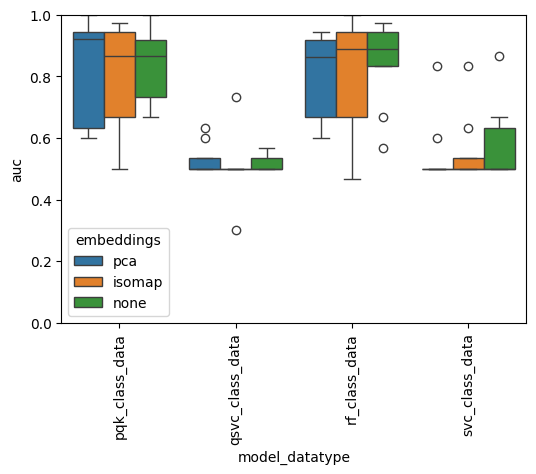

In [13]:
results_df['model_datatype'] = ['_'.join( [row.model, row.datatype] )  for idx, row in results_df.iterrows()]
for m in ['f1_score','accuracy', 'auc']:
    plt.figure( figsize=(6,4) )
    sns.boxplot( data = results_df, x = 'model_datatype', y = m, hue = 'embeddings' )
    plt.ylim( 0, 1)
    plt.xticks(rotation = 90 )
    plt.savefig( os.path.join( output_dir, tag + f'_{m}_boxplot.png'), bbox_inches='tight' )
    plt.show()
    plt.close()

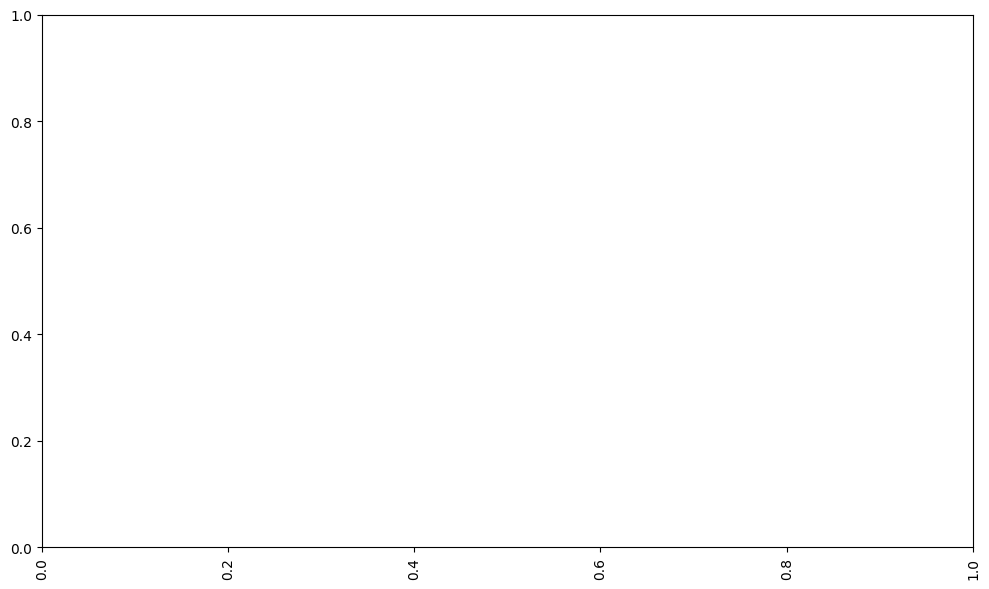

In [14]:
# Get the datasets for which the qml did better
# If there were no datasets in which QML outperformed CML, this cell returns a blank plot.
models_qml = ['qnn', 'vqc', 'qsvc' ]
df = results_df.copy()
df_across_split= df.groupby(['Dataset', 'embeddings', 'model'])['f1_score'].median().reset_index()
best_per_dataset = df_across_split.loc[df_across_split.groupby('Dataset')['f1_score'].idxmax()]
qml_winner = df_across_split[df_across_split['Dataset'].isin(best_per_dataset[best_per_dataset['model'].isin(models_qml)]['Dataset'])]
qml_winner['model'] = [ 'qml' if x in models_qml else 'cml' for x in qml_winner['model'] ]
plt.figure( figsize=(10,6))
sns.boxplot( data = qml_winner, x = 'Dataset', y = 'f1_score', hue = 'model' )
sns.swarmplot( data = qml_winner, x = 'Dataset', y = 'f1_score', hue = 'model' )
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()
plt.close()

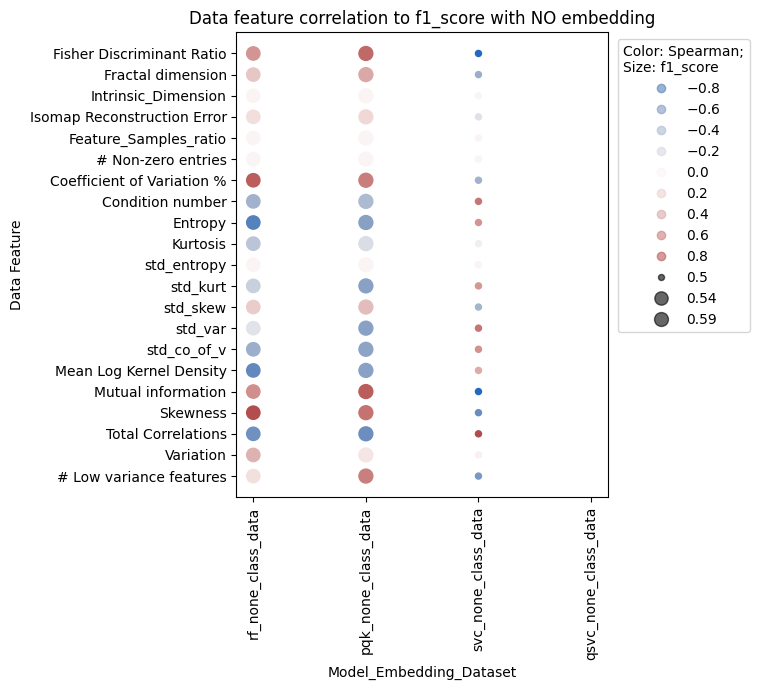

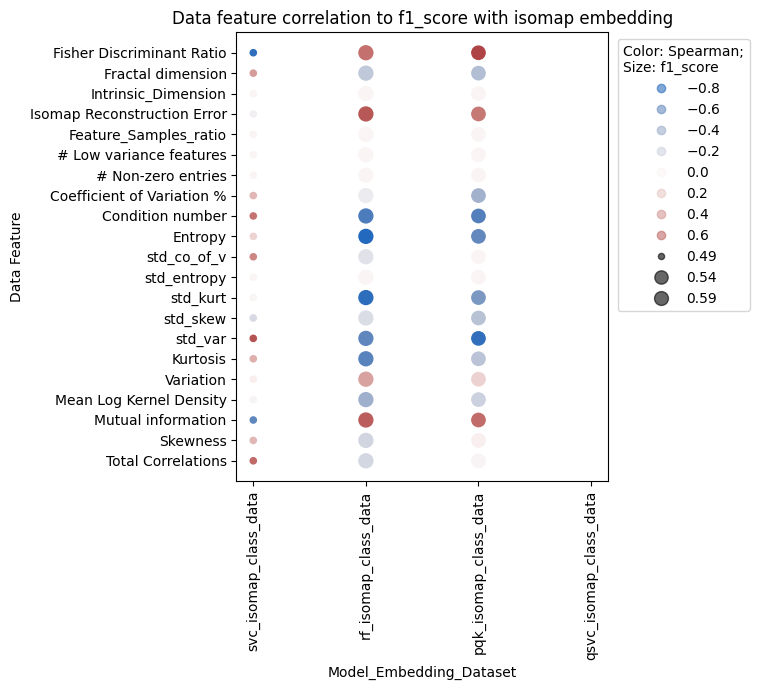

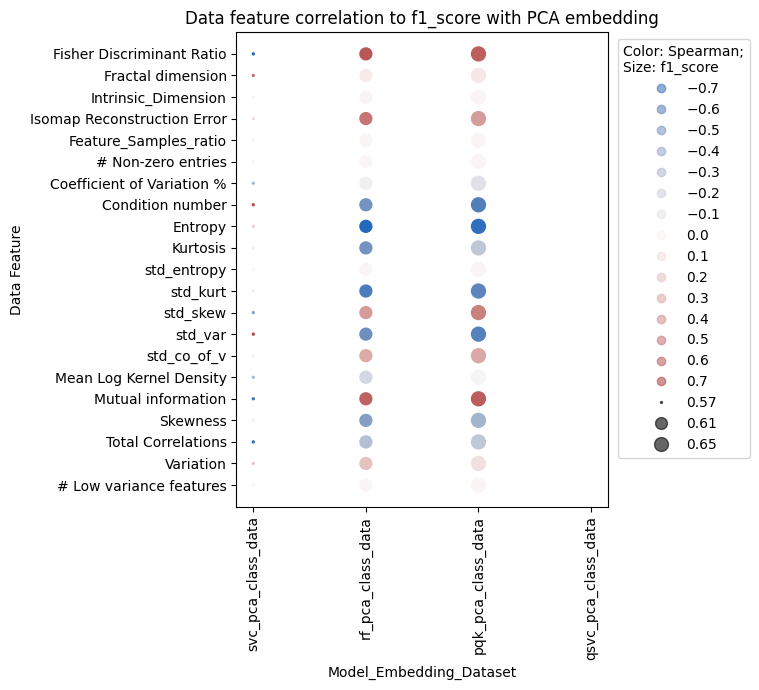

In [18]:
# Visualization correlation between data features and metric

_, correlation_spearman_df = qbc.compute_results_correlation(results_df=results_df, correlation='spearman', 
                                                                               thresh = 0.7)

# for m in ['f1_score', 'accuracy', 'auc' ]:
figsize = (9,7)
for m in ['f1_score']:
    qbc.plot_results_correlation( correlation_spearman_df[correlation_spearman_df['model_embed_datatype'].str.contains('_none_')],
                                                metric = m,
                                                title = 'Data feature correlation to ' + m + ' with NO embedding',
                                                correlation_type = 'Color: Spearman;\nSize: ' + m,
                                                size = 'median_metric',
                                                figsize=figsize,
                                                save_file_path=os.path.join( output_dir, tag + '_embed_NONE.png')
                                                )
    qbc.plot_results_correlation( correlation_spearman_df[correlation_spearman_df['model_embed_datatype'].str.contains('_isomap_')],
                                                metric = m,
                                                title = 'Data feature correlation to ' + m + ' with isomap embedding',
                                                correlation_type = 'Color: Spearman;\nSize: ' + m,
                                                size = 'median_metric',
                                                figsize=figsize,
                                                save_file_path=os.path.join( output_dir,tag + '_embed_isomap.png')
                                                )
    qbc.plot_results_correlation( correlation_spearman_df[correlation_spearman_df['model_embed_datatype'].str.contains('_pca_')],
                                                metric = m,
                                                title = 'Data feature correlation to ' + m + ' with PCA embedding',
                                                correlation_type = 'Color: Spearman;\nSize: ' + m,
                                                size = 'median_metric',
                                                figsize=figsize,
                                                save_file_path=os.path.join( output_dir, tag + '_embed_PCA.png')
                                                )
    # other values that can be used for size argument above include 'frac', 'median_metric', and 'frac_gt_thresh'

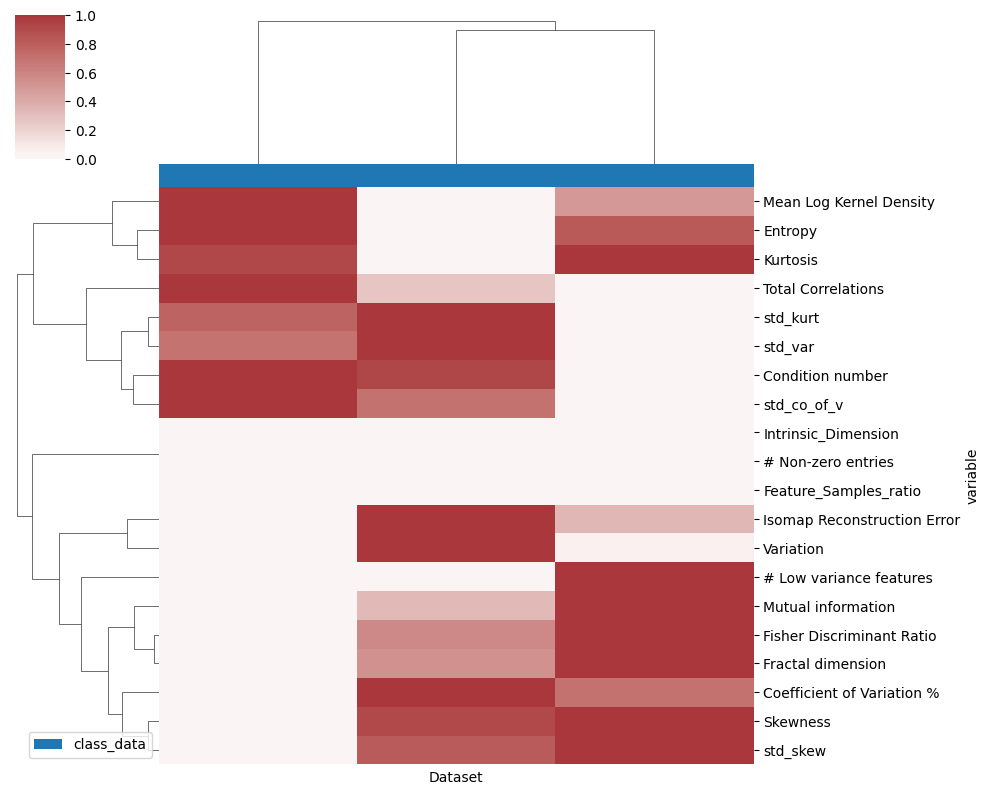

In [19]:
# let's reset the output directory for these plots
output_dir = 'performance_vs_data_complexity_plots'

features = ['Feature_Samples_ratio', 'Intrinsic_Dimension', 'Condition number',
    'Fisher Discriminant Ratio', 'Total Correlations', 'Mutual information',
    '# Non-zero entries', '# Low variance features', 'Variation', 'std_var',
    'Coefficient of Variation %', 'std_co_of_v', 'Skewness', 'std_skew',
    'Kurtosis', 'std_kurt', 'Mean Log Kernel Density',
    'Isomap Reconstruction Error', 'Fractal dimension', 'Entropy',
    ]
features.sort()
metrics = ['accuracy', 'f1_score', 'time', 'auc']
metrics.sort()

results_df = results_df.reset_index(drop=True)
results_df[results_df == math.inf] = 0
results_df = results_df.drop_duplicates()

#  You can either import rawwevals_df directly, or you can pull out the raw data evaluations from results_df by
#  keeping only the cases where no embedding was performed, and dropping the columns you don't want. 
raw_eval = results_df[( results_df.embeddings == 'none')]
raw_eval = raw_eval.drop(metrics + ['model_embed_datatype', 'embeddings', 'iteration', 'model', 'Model_Parameters'], axis = 1).drop_duplicates()
# raw_eval = raw_eval.drop(metrics + ['model_embed_datatype', 'embeddings', 'iteration'], axis = 1).drop_duplicates()
raw_eval = raw_eval.drop_duplicates()

#results_df = results_df[( results_df.embeddings != 'none') ]
results_df.shape
results_df.columns

embeddings = list(set(results_df['embeddings']))
#embeddings.remove('none')
embeddings.sort()
models = list(set(results_df['model']))
models.sort()
datatypes = list(set(results_df['datatype']))
datatypes.sort()

models_qml = ['qnn', 'vqc', 'qsvc' ]
models_cml = [ x for x in models if x not in models_qml ]


df_temp = raw_eval.copy()
# If your results inlcude only embeddings, you can use the following line to get the raw data evaluations instead.
#df_temp = rawevals_df.copy()
df_temp = df_temp[ ['Dataset'] + features ]
df_temp = df_temp.drop_duplicates()
df_temp = df_temp.melt( id_vars='Dataset', value_vars=features)
df_temp = df_temp.pivot_table( index='Dataset', columns='variable', values='value')
df_temp['Coefficient of Variation %'] = [float(x) for x in df_temp['Coefficient of Variation %'] ]
df_temp['std_co_of_v'] = [float(x) for x in df_temp['std_co_of_v'] ]

df_temp[ df_temp == math.inf ] = 0

datasets = list( set([ re.sub( '-.*', '', re.sub( '.csv', '', x ) ) for x in  df_temp.index ] ) )

custom_palette = sns.color_palette(n_colors=len(datasets))
datasets_cmap = dict( zip( datasets, custom_palette ) )
rcolors = [ datasets_cmap[ re.sub( '-.*', '', re.sub( '.csv', '', x ) )] for x in  df_temp.index ]

df_temp = df_temp.fillna(0).transpose().apply( lambda x : (x - min(x))/(max(x)-min(x)), axis = 1).fillna(0)
g = sns.clustermap( data= df_temp, figsize=(10,8), cmap = 'vlag', center = 0, col_colors=rcolors, xticklabels=False )

# g = sns.clustermap( data= results_df_temp.fillna(0).transpose(), figsize=(17,8), standard_scale=0, cmap = 'vlag', center = 0, col_colors=rcolors, xticklabels=False )

# Add a legend for row colors
for label, color in datasets_cmap.items():
    g.ax_row_dendrogram.bar(0, 0, color=color, label=label)
g.ax_row_dendrogram.legend(loc="lower right")

plt.show()
plt.close()

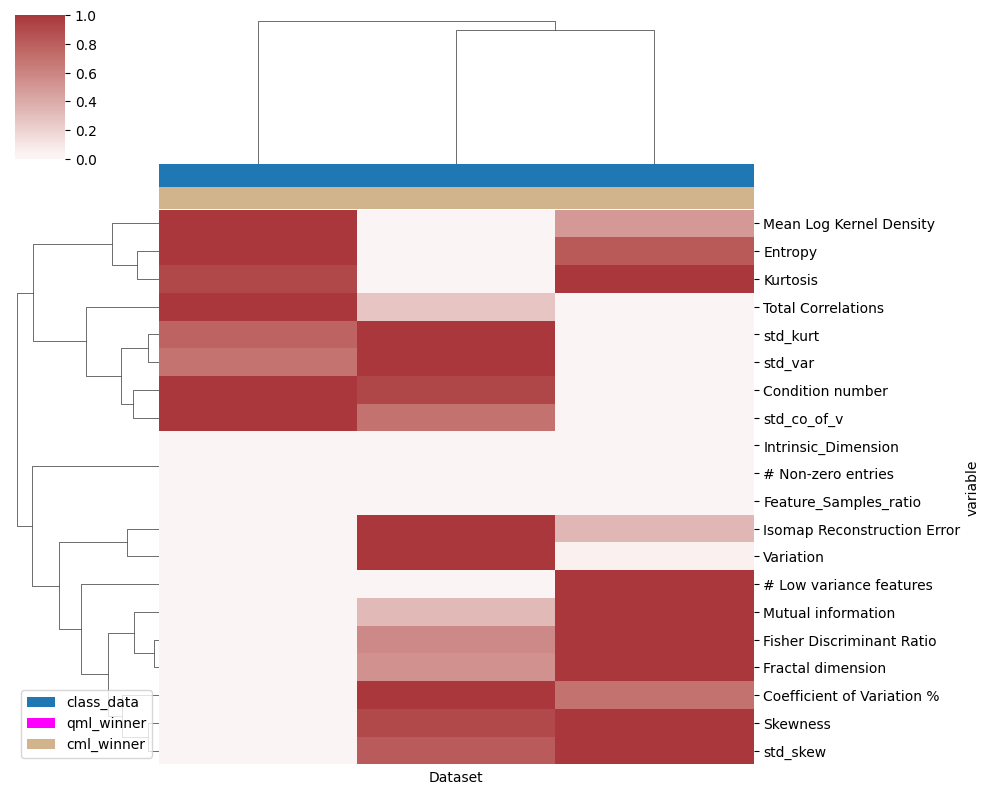

In [20]:
# reload the data frames
df_temp = raw_eval.copy()
df_temp = df_temp[ ['Dataset'] + features ]
df_temp = df_temp.drop_duplicates()
df_temp = df_temp.melt( id_vars='Dataset', value_vars=features)
df_temp = df_temp.pivot_table( index='Dataset', columns='variable', values='value')

df_temp[ df_temp == math.inf ] = 0

rcolors_df = []
rcolors_df.append( [ datasets_cmap[ re.sub( '-.*', '', re.sub( '.csv', '', x ) )] for x in  df_temp.index ] )
rcolors_df.append( [ 'magenta' if x in list(qml_winner['Dataset']) else 'tan' for x in  df_temp.index ] )

df_temp = df_temp.fillna(0).transpose().apply( lambda x : (x - min(x))/(max(x)-min(x)), axis = 1).fillna(0)
g = sns.clustermap( data= df_temp, figsize=(10,8), cmap = 'vlag', center = 0, col_colors=rcolors_df, xticklabels=False )

# g = sns.clustermap( data=results_df_temp.fillna(0).transpose(), figsize=(17,8), standard_scale=0, cmap = 'vlag', center = 0, col_colors=rcolors_df, xticklabels=False )

# Add a legend for row colors
datasets_cmap.update( { 'qml_winner' : 'magenta', 'cml_winner' : 'tan'})
for label, color in datasets_cmap.items():
    g.ax_row_dendrogram.bar(0, 0, color=color, label=label)
g.ax_row_dendrogram.legend(loc="lower right")

plt.show()
plt.close()

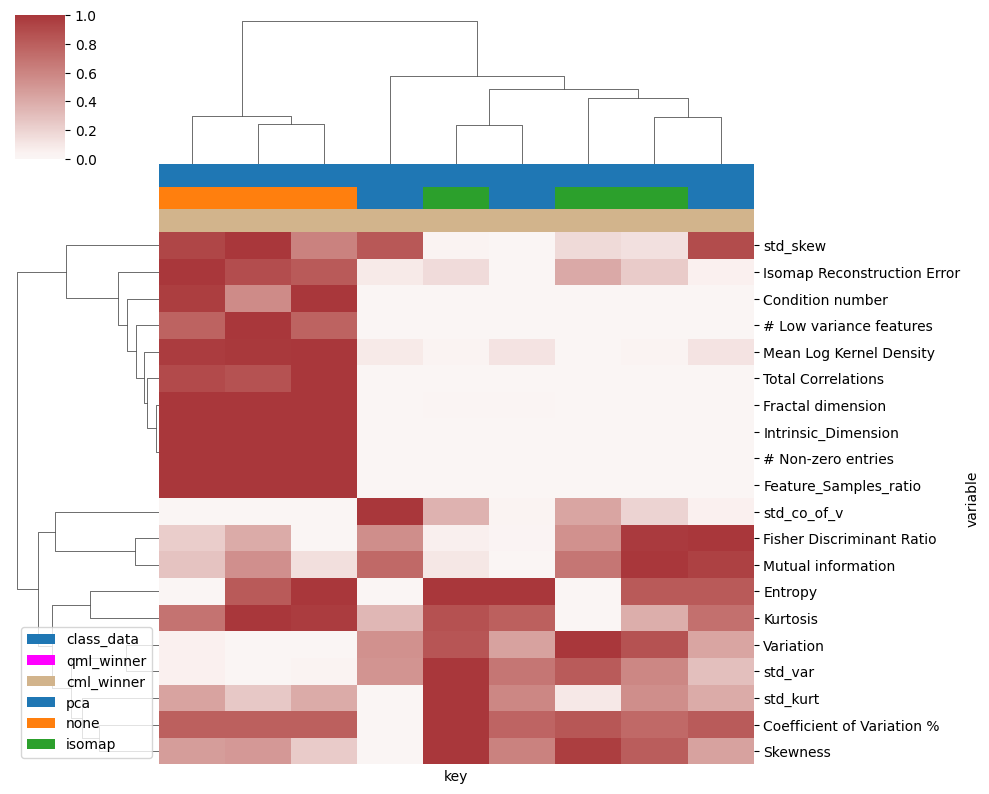

In [21]:
results_df_temp = results_df.copy()
results_df_temp['key'] = [ '_'.join( [row.embeddings, row.Dataset] ) for idx, row in results_df_temp.iterrows() ]
results_df_temp = results_df_temp[ ['key'] + features ]
results_df_temp = results_df_temp.drop_duplicates()
results_df_temp = results_df_temp.melt( id_vars='key', value_vars=features)
results_df_temp = results_df_temp.pivot_table( index='key', columns='variable', values='value')

results_df_temp[ results_df_temp == math.inf ] = 0
qml_winner['embed_dataset'] = [ '_'.join( [row.embeddings, row.Dataset]) for idx, row in qml_winner.iterrows() ]

embeds = list( set([ re.sub( '_.*', '', re.sub( '.csv', '', x ) ) for x in  results_df_temp.index ] ) )

custom_palette = sns.color_palette(n_colors=len(embeds))
embeds_cmap = dict( zip( embeds, custom_palette ) )

rcolors_df = []
rcolors_df.append( [ datasets_cmap[ '_'.join(re.sub( '-.*', '', re.sub( '.csv', '', x )).split('_')[1:])] for x in  results_df_temp.index ] )
rcolors_df.append( [ embeds_cmap[ re.sub( '_.*', '', x ) ] for x in  results_df_temp.index ] )
rcolors_df.append( [ 'magenta' if x in list(qml_winner['embed_dataset']) else 'tan' for x in  results_df_temp.index ] )

df_temp = results_df_temp.fillna(0).transpose().apply( lambda x : (x - min(x))/(max(x)-min(x)), axis = 1).fillna(0)
g = sns.clustermap( data= df_temp, figsize=(10,8), cmap = 'vlag', center = 0, col_colors=rcolors_df, xticklabels=False )

# g = sns.clustermap( data=results_df_temp.fillna(0).transpose(), figsize=(17,8), standard_scale=0, cmap = 'vlag', center = 0, col_colors=rcolors_df, xticklabels=False )

# Add a legend for row colors
datasets_cmap.update(embeds_cmap)
datasets_cmap.update( { 'qml_winner' : 'magenta', 'cml_winner' : 'tan'})

for label, color in datasets_cmap.items():
    g.ax_row_dendrogram.bar(0, 0, color=color, label=label)
g.ax_row_dendrogram.legend(loc="lower right")

plt.show()
plt.close()

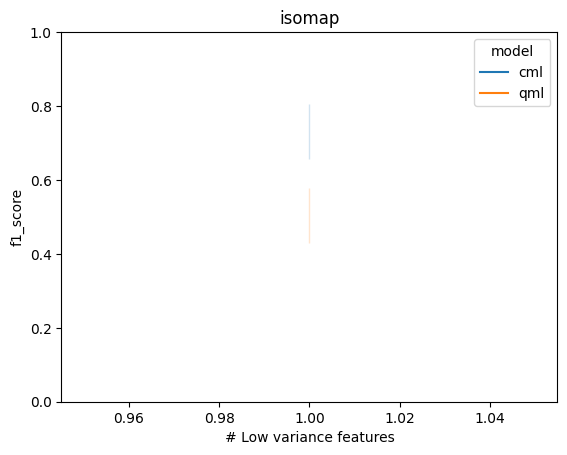

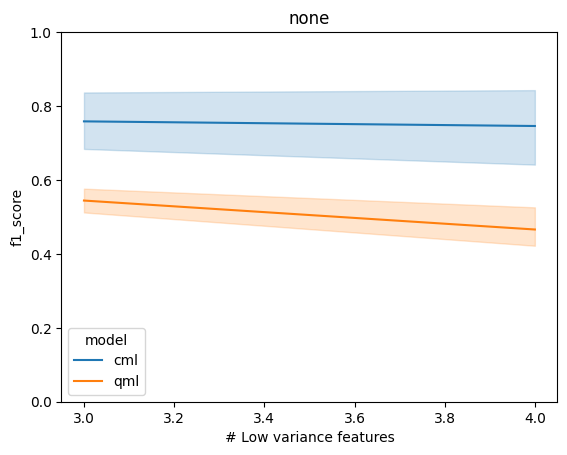

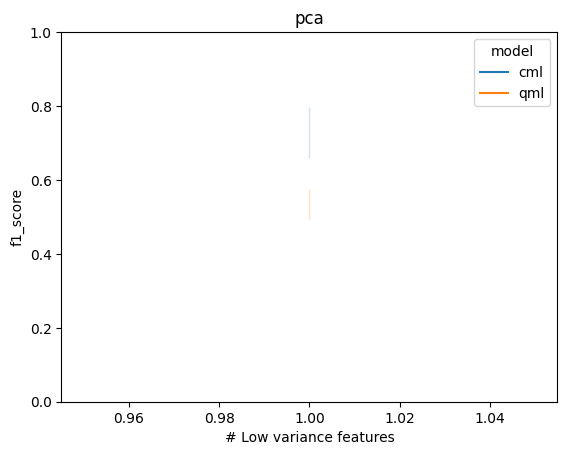

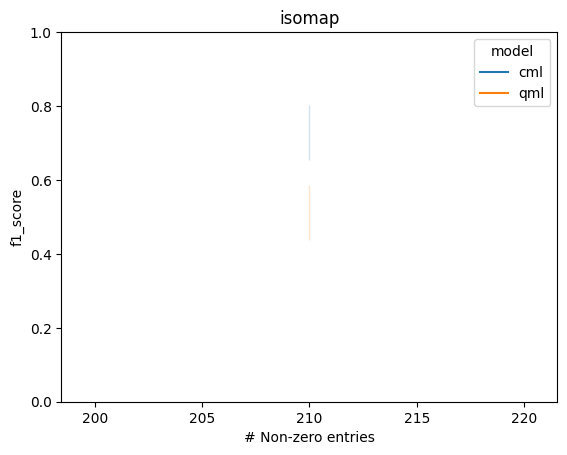

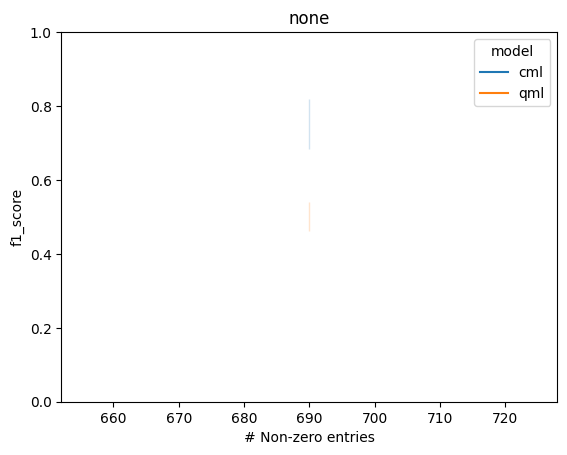

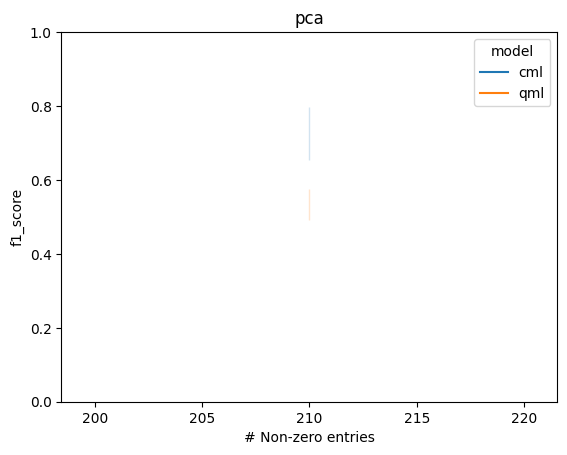

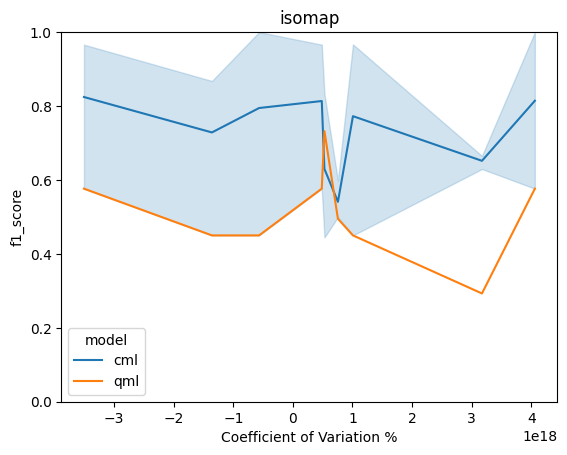

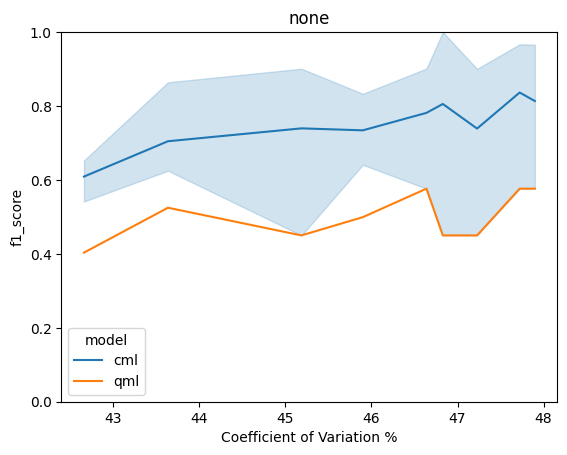

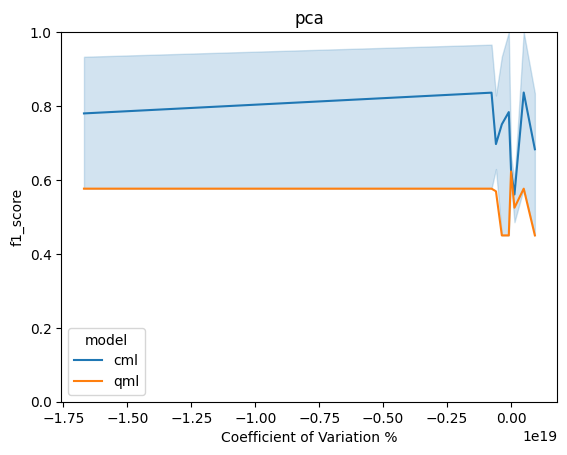

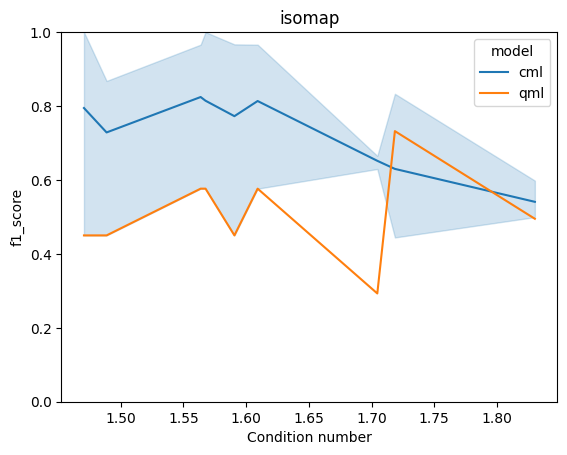

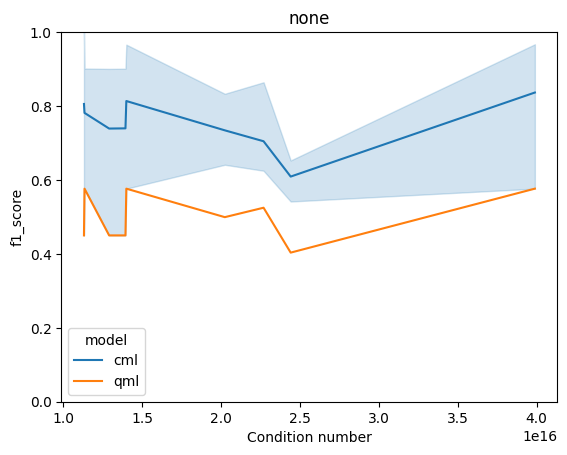

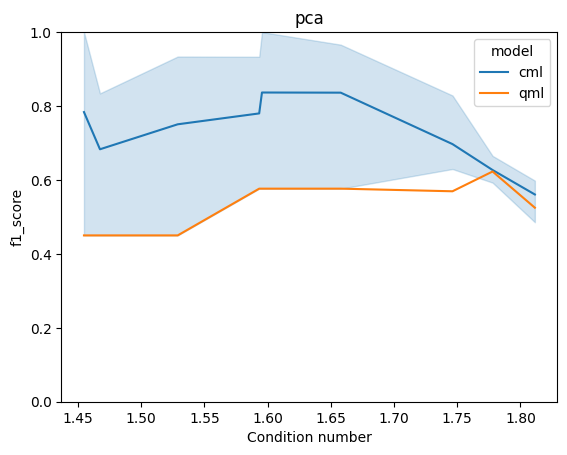

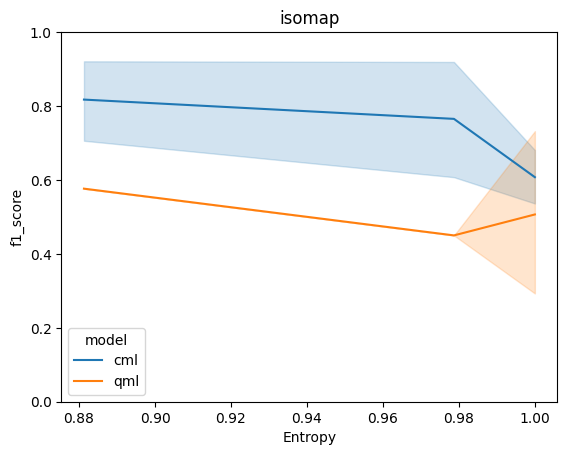

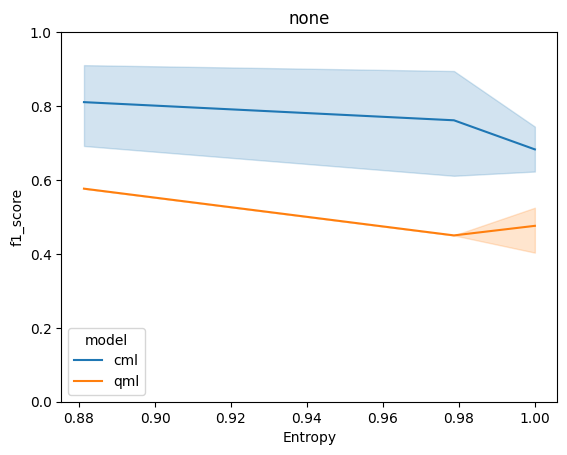

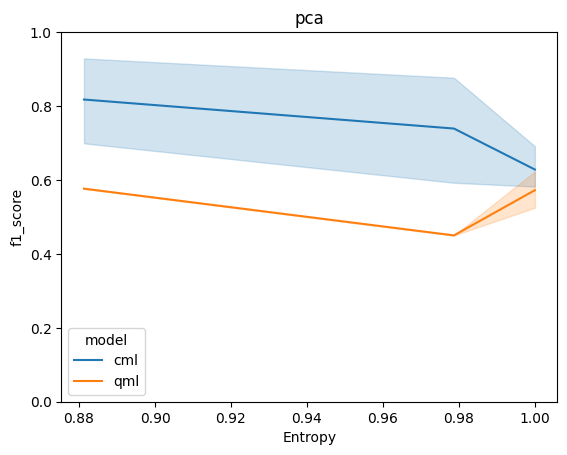

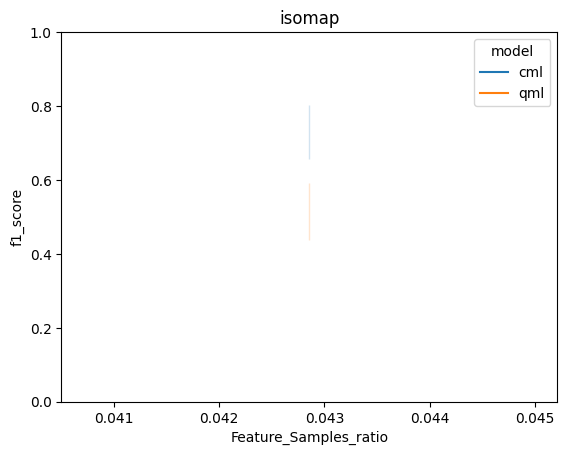

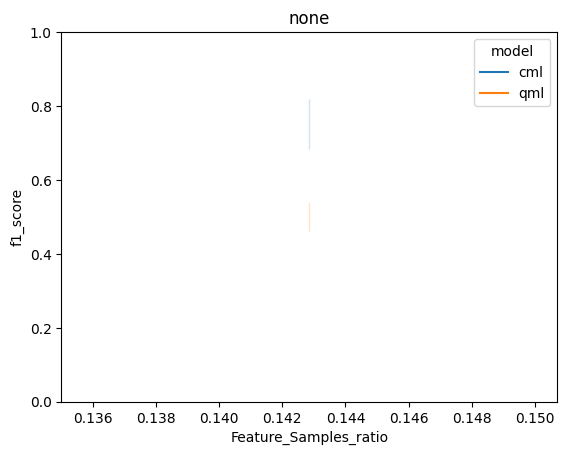

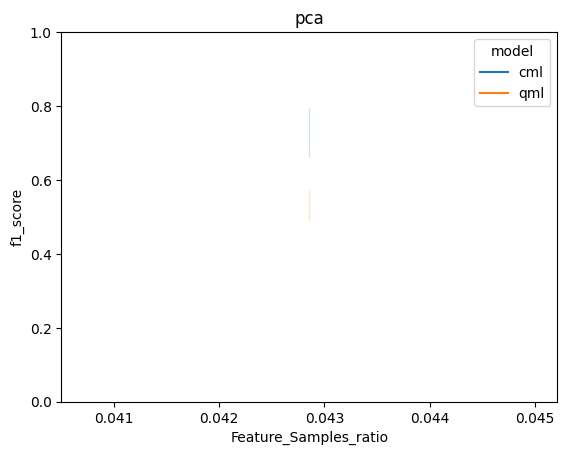

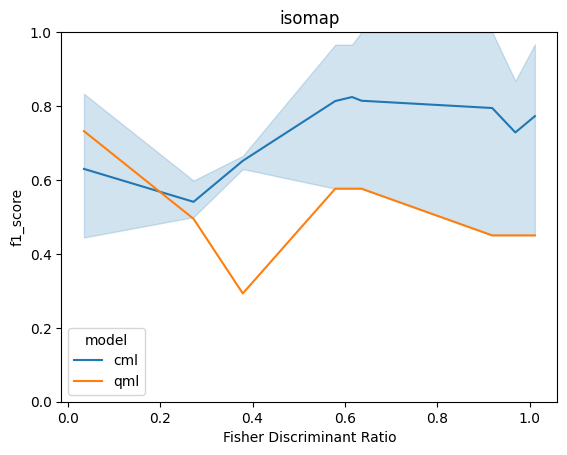

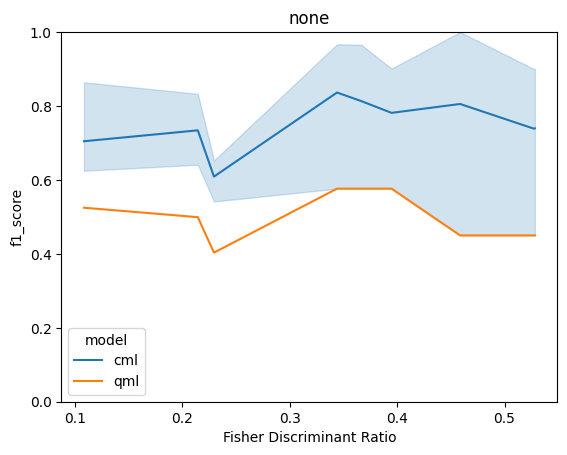

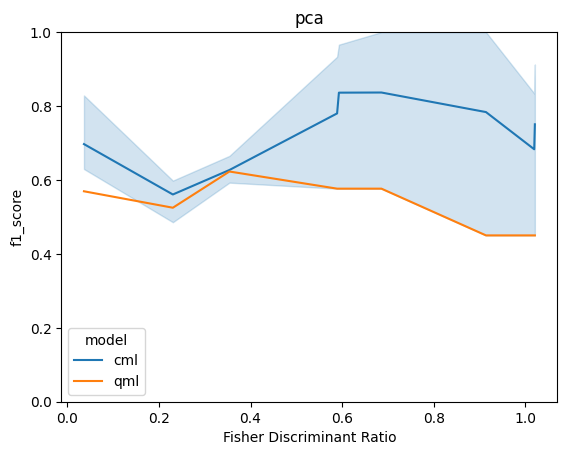

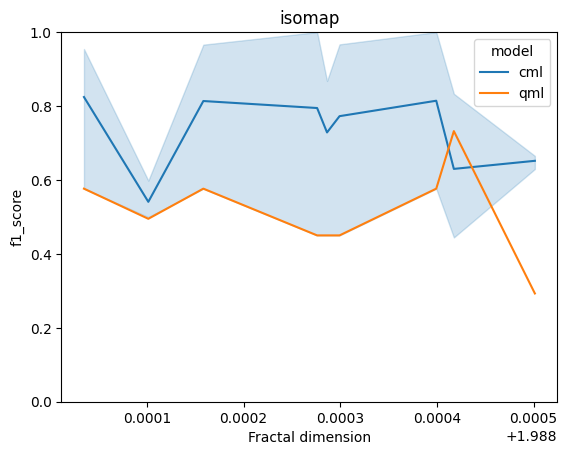

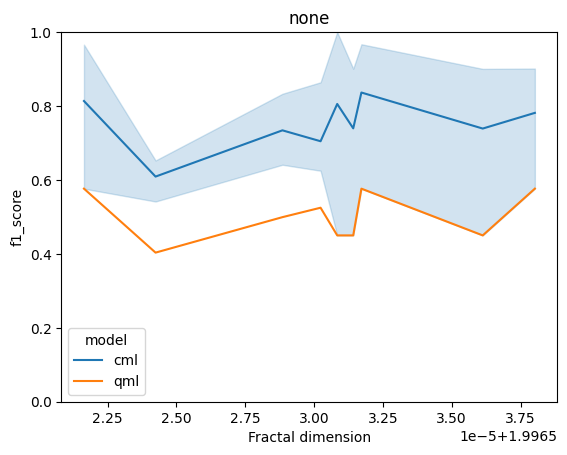

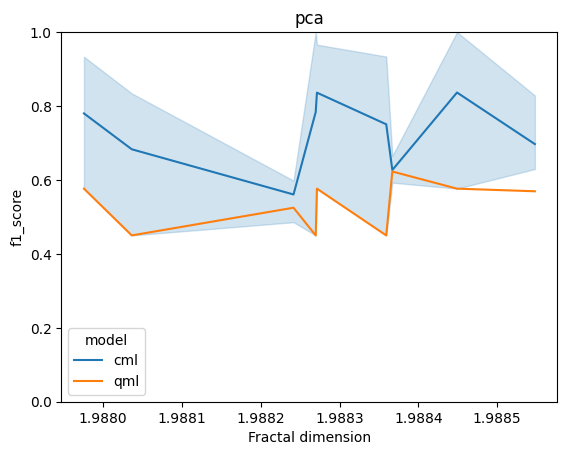

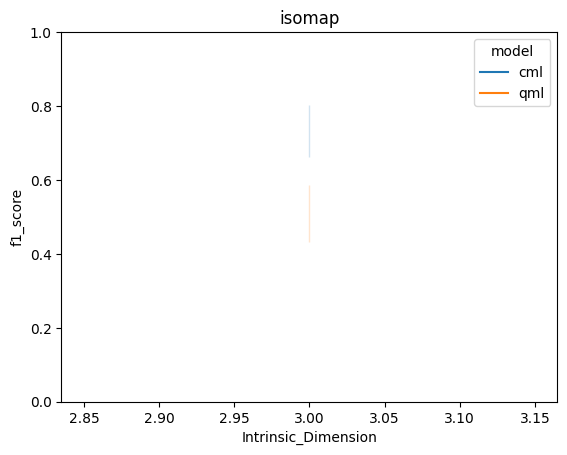

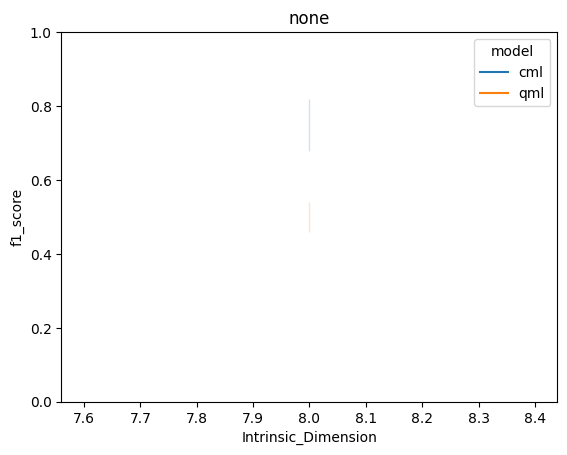

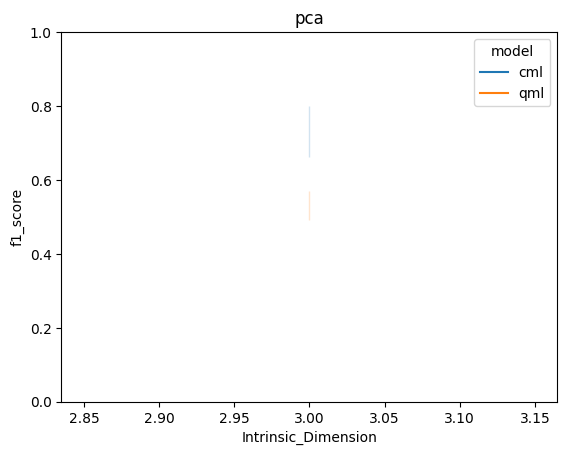

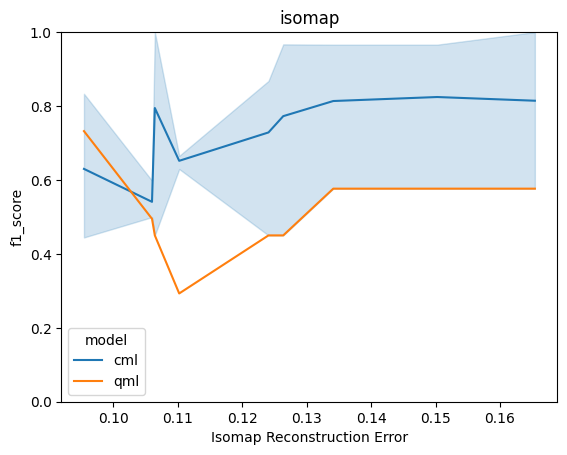

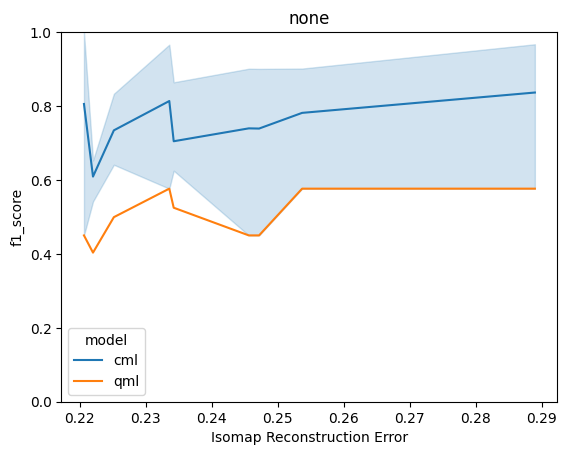

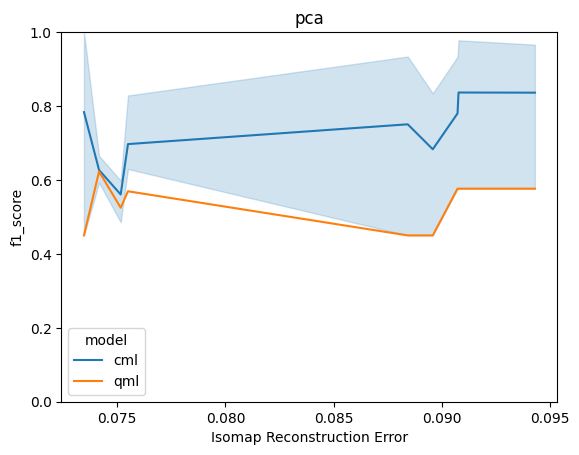

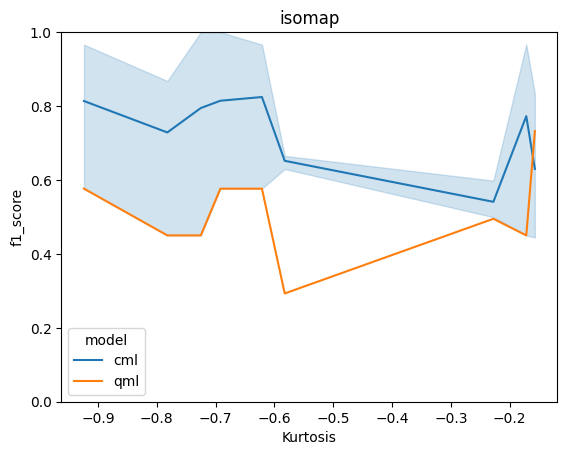

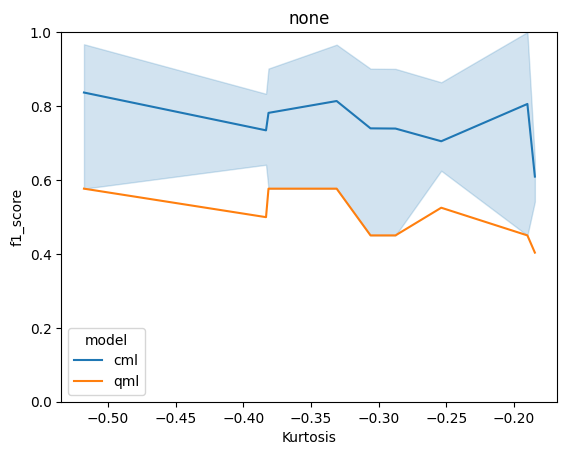

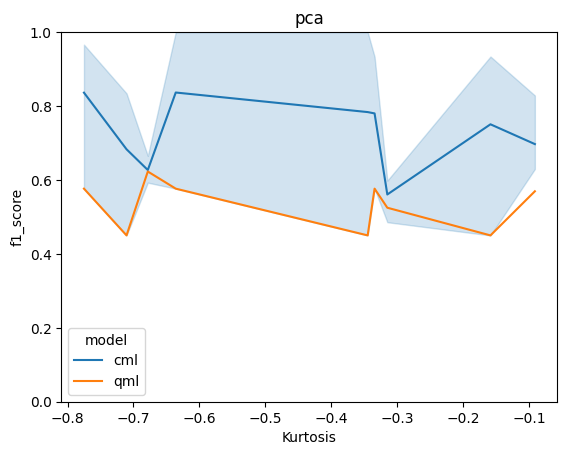

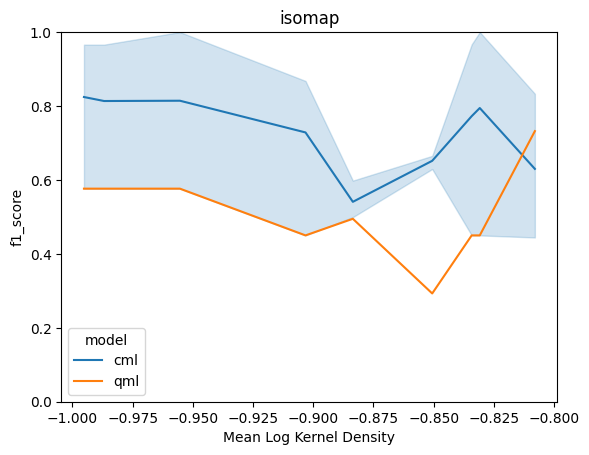

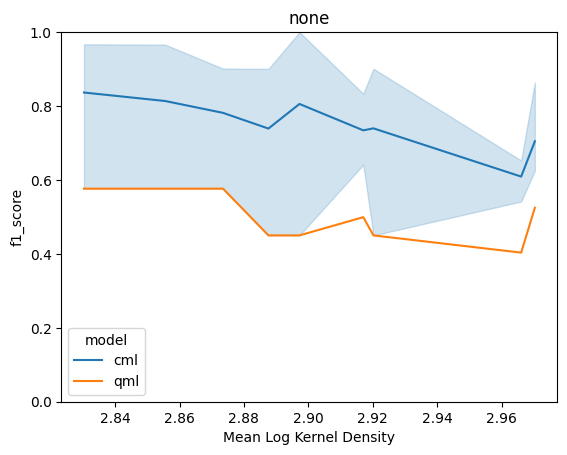

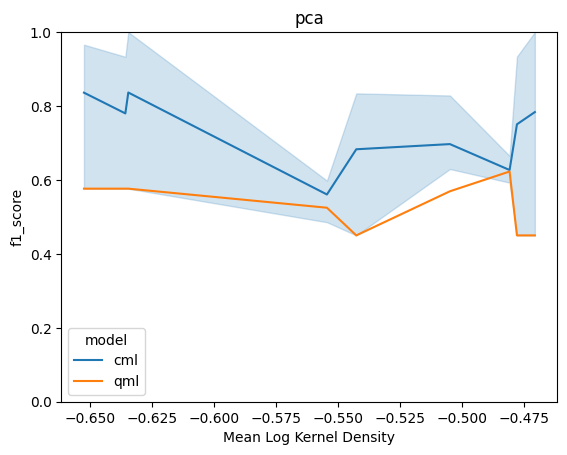

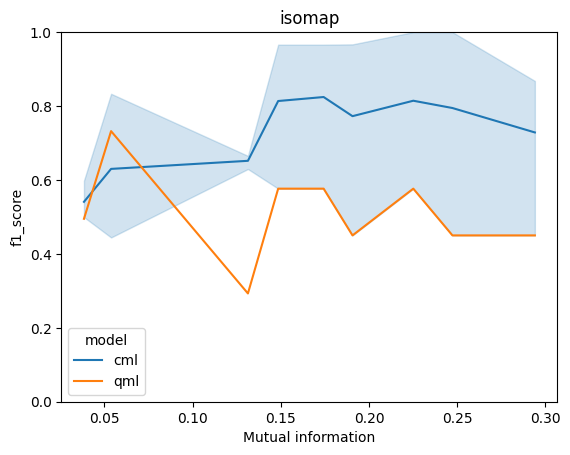

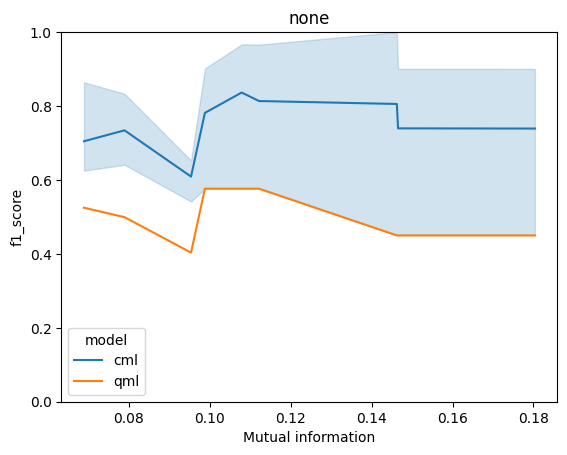

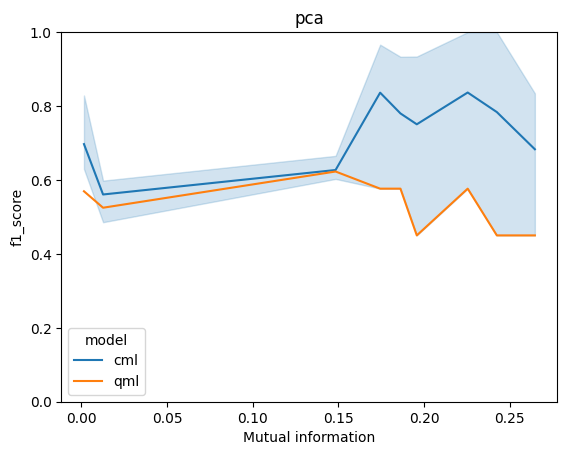

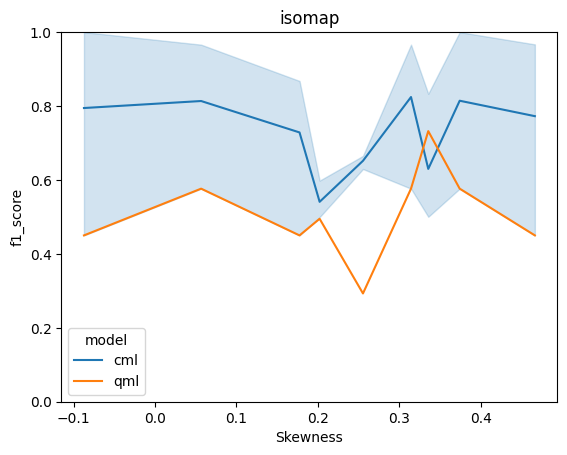

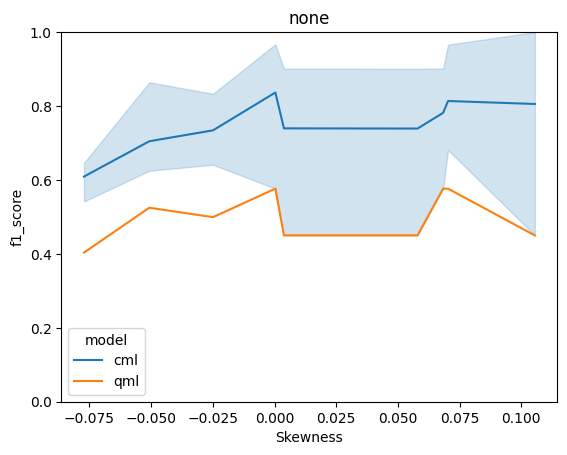

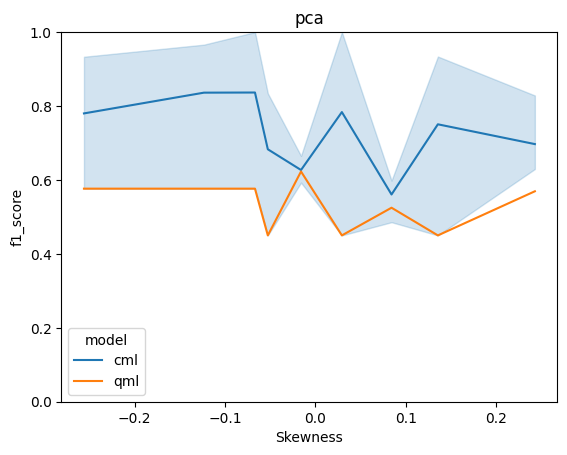

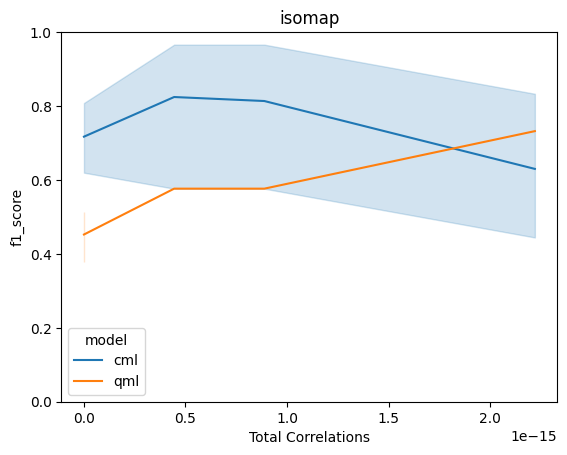

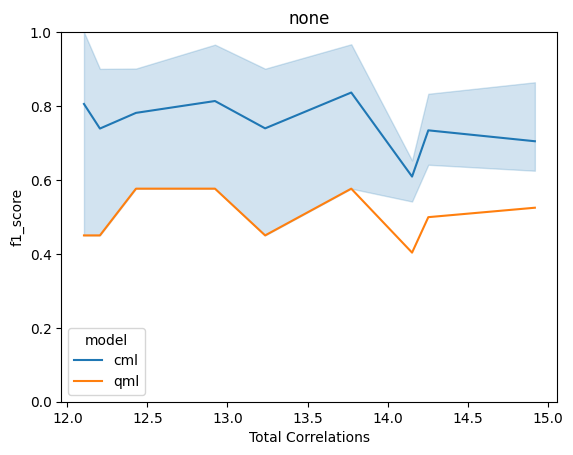

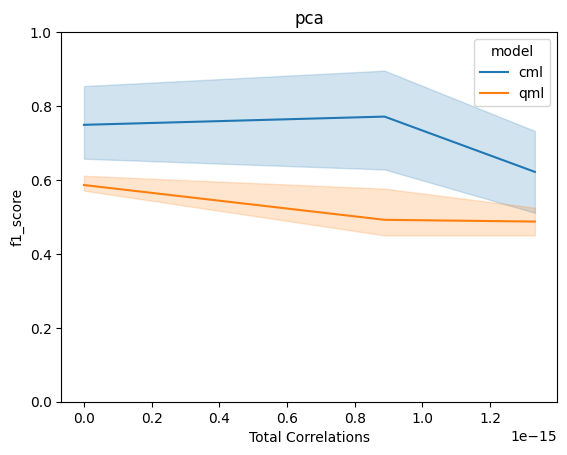

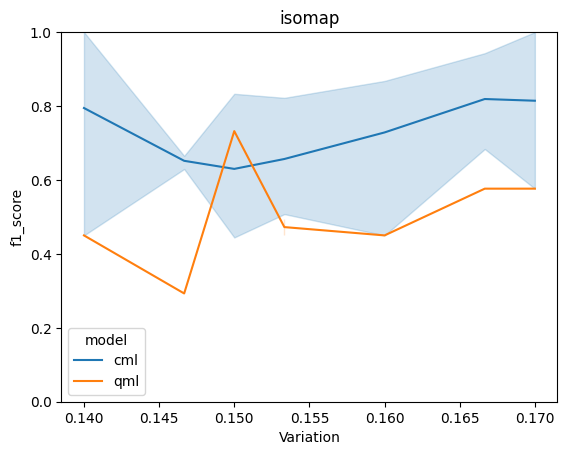

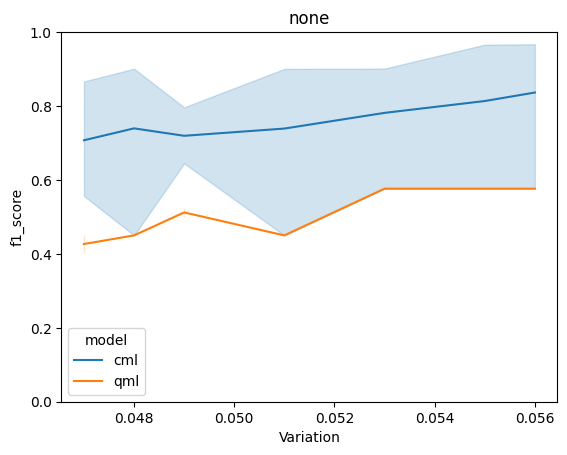

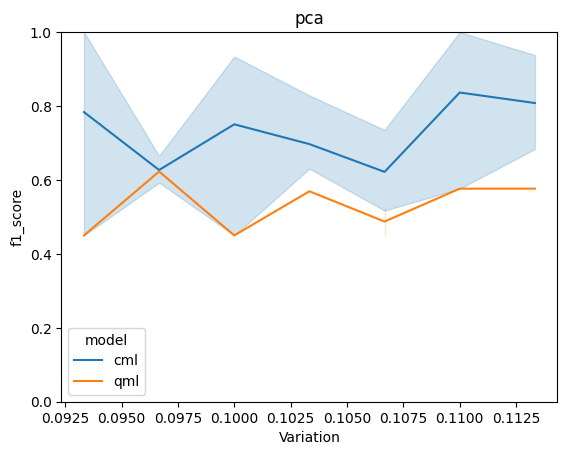

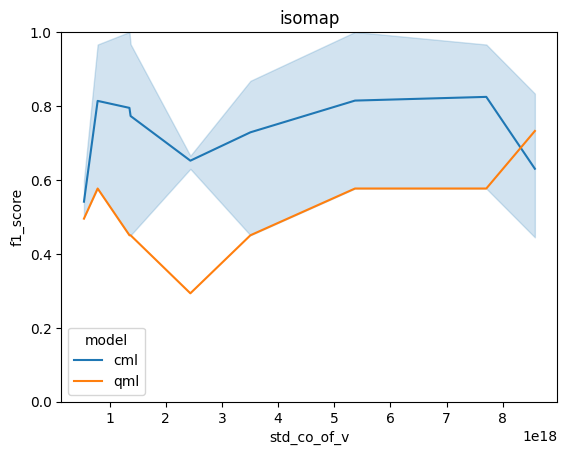

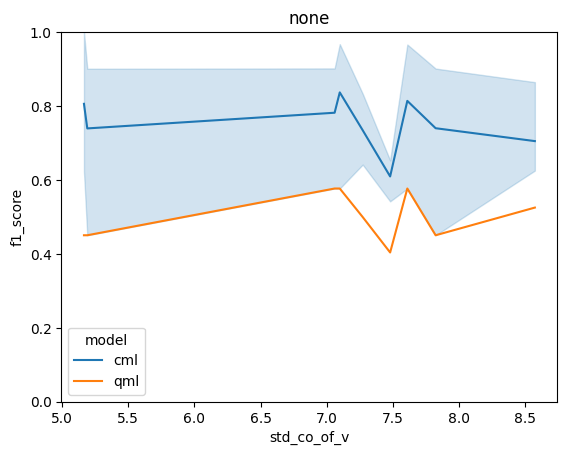

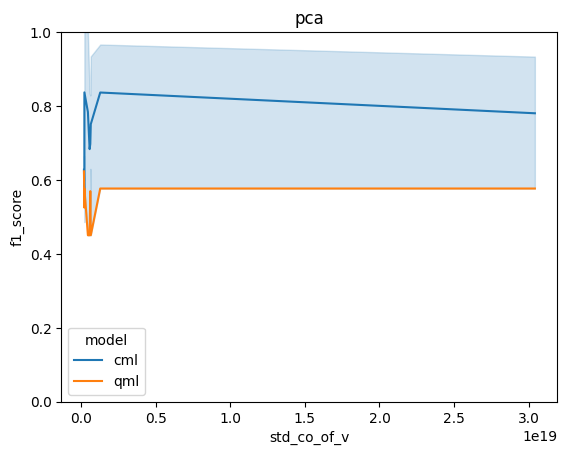

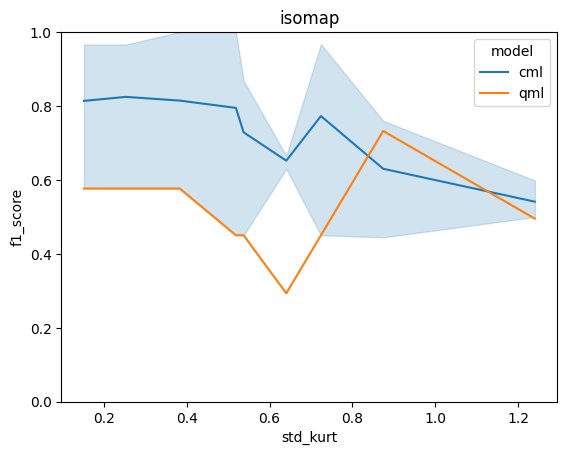

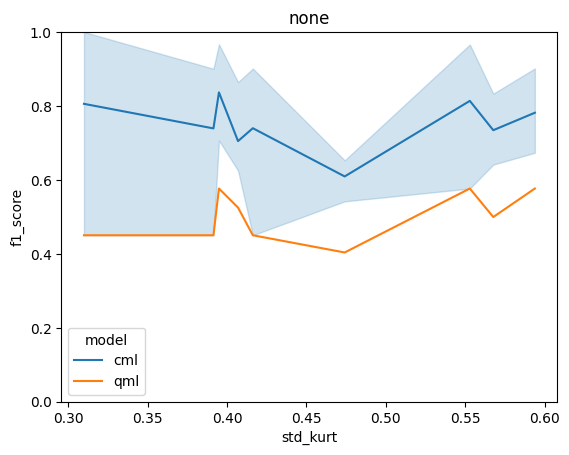

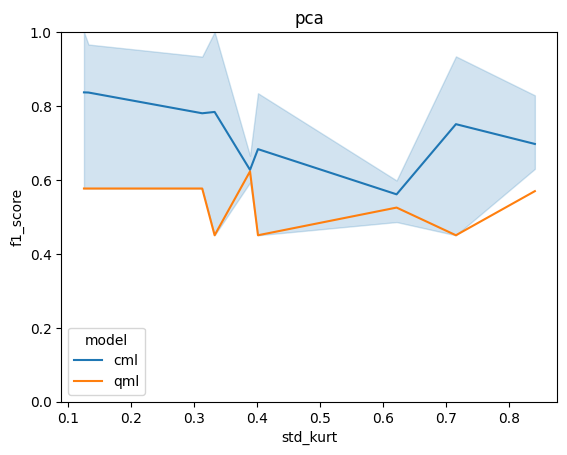

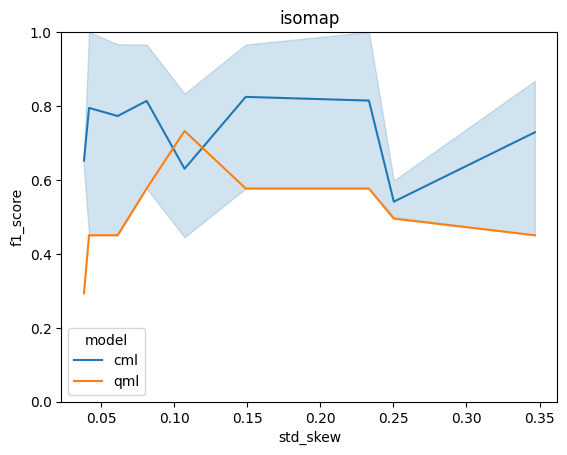

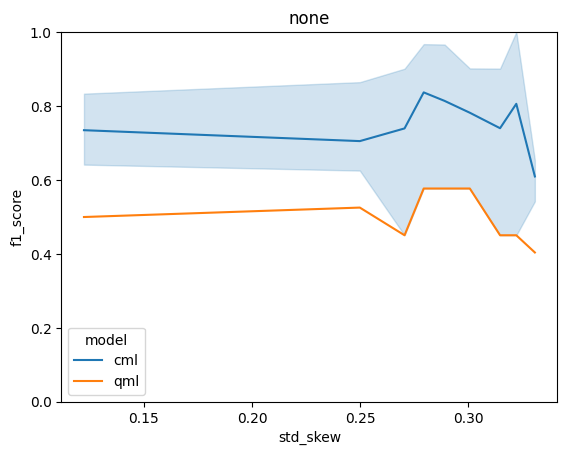

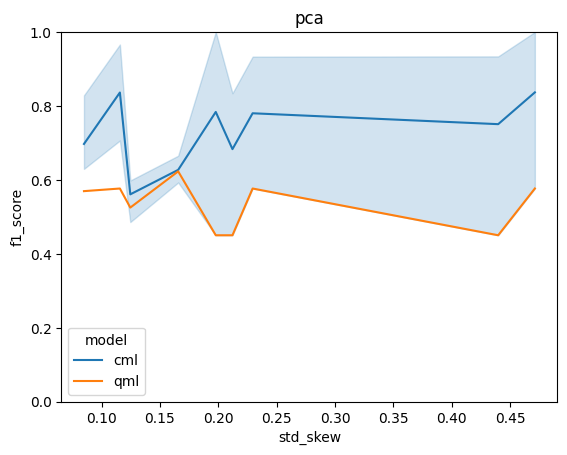

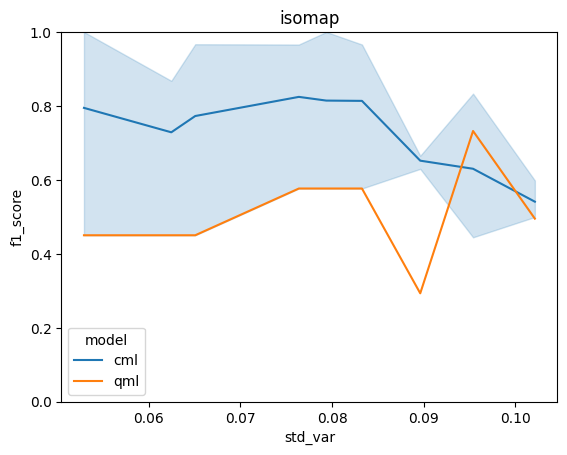

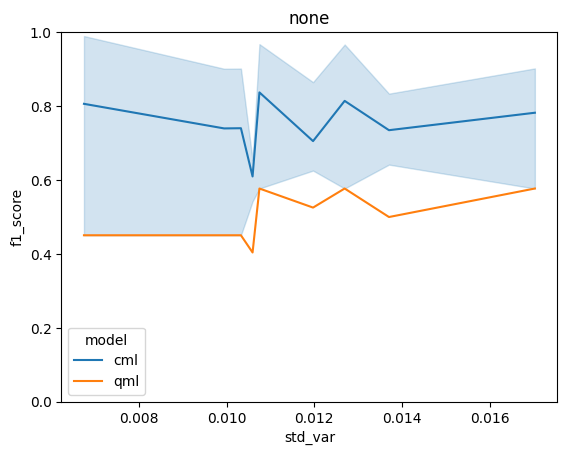

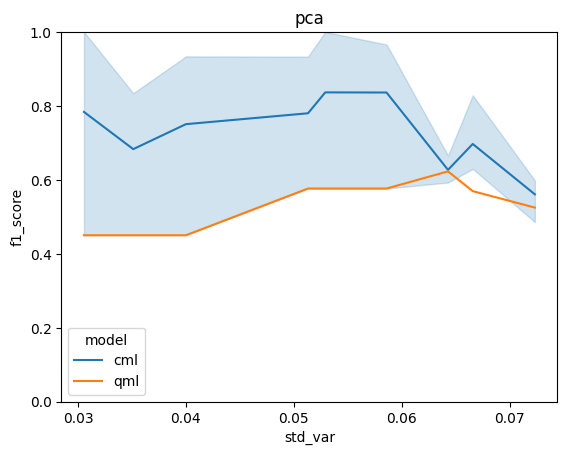

In [22]:
for m in ['f1_score']:
# for m in ['f1_score', 'auc', 'accuracy' ]:
    for f in features:
        for e in embeddings:
            to_plot = results_df[ (~results_df[metrics[0]].isna()) & ( results_df['embeddings'] == e ) ]
            to_plot['model'] = [ 'qml' if x in models_qml else 'cml' for x in to_plot['model']]
            sns.lineplot(
                        data = to_plot,
                        x = f,
                        y = m,
                        hue = 'model',
                    )
            plt.title( e )
            plt.ylim(0,1)
            plt.show()
            plt.close()